In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import seaborn as sns

import pandas as pd
from sklearn import cluster, datasets
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

## Loading data

In [16]:
# Load data
y_train = pd.read_csv("truth3.csv")
x_train = pd.read_csv("data3.csv")
x_train.rename(columns={'time sample band g': 'time_g', 'time sample band r': 'time_r',
                    'time sample band i': 'time_i','total flux + noise band g': 'tfnbg',
                    'total flux + noise band r': 'tfnbr', 'total flux + noise band i': 'tfnbi',}, inplace=True)

In [17]:
y_train.head()

,ID,images,time origin,amplitude,redshift,noise level
0,0.001477,2.0,55000.0,0.0061,1.8656,0.0649
1,0.016771,4.0,55000.0,0.0205,1.8798,0.1088
2,0.016706,4.0,55000.0,0.0207,1.3017,0.1550
3,0.003699,1.0,55000.0,0.0330,1.2236,0.0916
4,0.007447,1.0,55000.0,0.0994,2.1970,0.0341


In [18]:
x_train.head()

,ID,images,time_g,tfnbg,time_r,tfnbr,time_i,tfnbi
0,0.001477,2,54958.5867,5.683103,54959.5867,875.712403,54961.9867,2190.502931
1,0.001477,2,54961.3867,-275.212679,54960.3867,146.964582,54966.1867,3102.795917
2,0.001477,2,54962.1867,967.257555,54962.1867,787.248505,54969.3867,3120.273715
3,0.001477,2,54965.9867,356.030143,54962.9867,1277.598615,54971.5867,3839.919327
4,0.001477,2,54968.7867,416.647886,54964.7867,331.525059,54972.7867,5059.414626


## Checking balanced

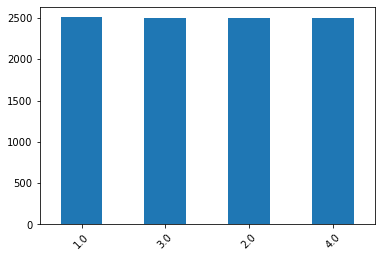

In [19]:
y_train.images.value_counts().plot(kind='bar')
plt.xticks(rotation = 45)
plt.show();

## Taking interesting features

In [20]:
feature_columns = x_train.columns.tolist()[1:4]
feature_columns

['images', 'time_g', 'tfnbg']

In [21]:
x_train.ID.value_counts()

0.000000    364
0.001477     91
0.000807     91
0.025572     91
0.006368     91
           ... 
0.000157     91
0.002991     91
0.006873     91
0.010983     91
0.003339     91
Name: ID, Length: 9995, dtype: int64

In [22]:
(x_train.ID.value_counts() ==91).sum() == len(y_train)

False

In [23]:
seq = []
for ide, group in x_train.groupby('ID'):
    seq_features = group[feature_columns]
    label = y_train[y_train.ID == ide].iloc[0]
    
    seq.append((seq_features, label))

In [24]:
train_seq, test_seq = train_test_split(seq, test_size=0.2)

In [25]:
len(train_seq), len(test_seq)

(7996, 1999)

## Dataset

In [26]:
class ImagesDataset(Dataset):
    
    def __init__(self, seq):
        self.sequences = seq
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence, label = self.sequences[idx]
        return dict(
            sequence = torch.Tensor(sequence.to_numpy()), 
            label = torch.tensor(label[0]).to(dtype=torch.long))

In [27]:
class ImagesDataModule(pl.LightningDataModule):
    
    def __init__(self, train_sequence, test_sequence, batch_size):
        super().__init__()
        self.train_sequence = train_sequence
        self.test_sequence = test_sequence
        self.batch_size = batch_size
        
    def setup(self, stage=None):
        self.test_dataset = ImagesDataset(self.test_sequence)
    
    def train_dataloader(self):
        return DataLoader(
            ImagesDataset(self.train_sequence),
            batch_size = self.batch_size,
            shuffle = False
            )
    
    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size = self.batch_size,
            shuffle = False
            )
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size = self.batch_size,
            shuffle = False
            )

## Model

In [28]:
class SequenceModel(nn.Module):
    
    def __init__(self, n_features, n_classes, n_hidden=256, n_layers=3):
        
        super().__init__()
        
        self.lstm = nn.LSTM(
            input_size = n_features,
            hidden_size = n_hidden,
            num_layers = n_layers,
            batch_first = True,
            dropout = 0.75
        )
        self.classifier = nn.Linear(n_hidden, n_classes)
    
    def forward(self, x):
        self.lstm.flatten_parameters()
        _, (hidden, _) = self.lstm(x)
        
        out = hidden[-1]
        return self.classifier(out)
        

In [29]:
torch.manual_seed(0)

In [30]:
model = SequenceModel(n_features = len(feature_columns), 
                        n_classes = 4)

In [31]:
print(model)

SequenceModel(
  (lstm): LSTM(3, 256, num_layers=3, batch_first=True, dropout=0.75)
  (classifier): Linear(in_features=256, out_features=4, bias=True)
)


## Training

In [32]:
# Hyperparameters

N_epochs = 250
batch_size = 64

In [33]:
# Dataloader definition

data_train = ImagesDataModule(train_seq, test_seq, batch_size)
train_loader = data_train.train_dataloader()

test_loader = ImagesDataset(test_seq)

In [34]:
# Loss function
loss_function = nn.CrossEntropyLoss()

In [35]:
# Optimizer:
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Network training

In [36]:
losses = []  
val_losses = []
i=0
for epoch in range(N_epochs):  # Loop over epochs
    running_loss = 0.0
   
    for features, labels in train_loader:        
        
        # Forward Propagation 
        labels_pred = model(features)
        labels_val_pred = model(features_val)

        # Loss computation
        loss = loss_function(labels_pred,labels)

        # Save loss for future analysis
        losses.append(loss.item())
        val_loss = loss_function(labels_val_pred,labels_val)
        val_losses.append(val_loss.item())

        # Erase previous gradients
        optimizer.zero_grad()
        
        # Compute gradients (backpropagation)
        loss.backward()

        # Weight update
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    
            print('[Epoque : %d, iteration: %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0
        i+=1        
   
    print('Training done')

AttributeError: 'str' object has no attribute 'dim'